In [1]:
import os
os.environ['MATPLOTLIBRC'] = "../matplotlibrc" 
BSU_BLUE = "#0033A0"
BSU_ORANGE = "#D64309"
from common import *

In [2]:
data_path = "/home/sthomas/projects/LJ_System_Size"
import signac
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
from scipy.signal import argrelextrema as argex
import matplotlib.cm as cm
import itertools
import os
#import structure_factor as sf
import math
from scipy import interpolate
import gsd
import gsd.fl
import gsd.hoomd

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D


            
names={'iso':'Isothermal','lin_ramp':'Linear Ramp','step':'Step'}
colors={'iso':'C0','lin_ramp':'C1','step':'C2'}
markers={'iso':'s','lin_ramp':'P','step':'>'}
linestyles={'iso':'-','lin_ramp':'--','step':'-.'}

project = signac.get_project(data_path)
df_index = pd.DataFrame(project.index())
df_index = df_index.set_index(['_id'])
statepoints = {doc['_id']: doc['statepoint'] for doc in project.index()}
df = pd.DataFrame(statepoints).T.join(df_index)
df = df.sort_values('T')
#df.head()

In [3]:
typeId=2
n_views=40
grid_size=512
gammas = [4.5]#,18,36,72]#[4.5,9,18,36,45,52,72]
colors = itertools.cycle(cm.rainbow(np.linspace(0, 1, len(gammas))))
for gamma in gammas:
    df_filtered = df[(df.n_particles==1000000)&
                   (df.t_Final==1e7)&
                     (df.trial==0)]
                   # (df.t_Final==6e6)]


    #print(df_filtered)
    #grpedByGamma = df_filtered.groupby('profile')#.apply(lambda x: x.sort_values('T'))
    times_for_all_trials=[]
    qs_for_all_trials=[]
    Is_for_all_trials=[]
        
    qms_all=[] #qmax
    Is_all=[]
    Qs_all=[]
    times_all=[]
    cure_all=[]
    color=next(colors)
    for signac_id in df_filtered['signac_id']:
        job = project.open_job(id=signac_id)

        if 'Lx' in job.document:
            half_box_length = job.document['Lx']/2
        else:
            print('Lx not found in',job)
            
        q_half_length = 2*math.pi/(half_box_length/1.06)
        diffract_dir_pattern ='diffract_type_{}_n_views_{}_grid_size_{}_frame'.format(typeId,
                                                                                     n_views,
                                                                                     grid_size)
        directories = os.listdir(job.workspace())
        directories = [d for d in os.listdir(job.workspace()) if d.startswith(diffract_dir_pattern)]
        directories.sort(key = lambda x: int(x.split('_')[-1]))
        #print(len(directories))
        #print(directories)
        num_frames = len(directories)
        
        qs_for_all_times=[]
        Is_for_all_times=[]
        times_for_all_times=[]
        qs_list = []
        times_list = []
        Is_list = []  
        Qs_list=[]
        for i,diffract_dir in enumerate(directories):
            print("Progress {:2.1%}".format(i / num_frames), end="\r")
            if diffract_dir.startswith(diffract_dir_pattern):
                frame = int(diffract_dir.split('_')[-1])
                if frame%1==0 and frame >0e6/job.sp.dcd_write:#==119 or frame==123:#%100 == 0:#num_frames/30:
                    if job.isfile('{}/asq.txt'.format(diffract_dir)):
                        #print(job.fn('{}/asq.txt'.format(diffract_dir)))
                        data=np.genfromtxt(job.fn('{}/asq.txt'.format(diffract_dir)))
                        time = round(frame*job.sp.dcd_write)
                        legend = '{} $\\Delta t(\Gamma:{})$'.format(time,job.sp.gamma)
                        qs = data[:,0]
                        Is = data[:,1] 
                        #print(qs.shape)
                        qs_for_all_times.append(qs)
                        Is_for_all_times.append(Is)
                        times_for_all_times.append(time)
                        
                        dq=qs[1]-qs[0]
                        Is_exp = np.exp(Is)
                        q_sq = qs**2
                        Q = np.sum(Is_exp*qs*dq)
                        Qs_list.append(Q)
                        first_peak_q,first_peak_i = get_highest_maxima(job.document['Lx'],qs,Is)
                        #print(first_peak_q,first_peak_i)
                        if first_peak_q is None:
                            #print(q_half_length)
                            fn = interpolate.interp1d(qs,Is,kind='cubic')
                            first_peak_q=q_half_length
                            first_peak_i=fn(first_peak_q)
                        if first_peak_q >0.8:# and time > 2.0e5:
                            fn = interpolate.interp1d(qs,Is,kind='cubic')
                            first_peak_q=q_half_length
                            first_peak_i=0#fn(first_peak_q)
                        qs_list.append(first_peak_q)
                        times_list.append(time)
                        Is_list.append(first_peak_i)
                    else:
                        print(job,'did not contain diffraction data in ',diffract_dir)

        qs_for_all_trials.append(qs_for_all_times)#this is to plot the S(q)
        Is_for_all_trials.append(Is_for_all_times)
        times_for_all_trials.append(times_for_all_times)
        
        qms_all.append(np.asarray(qs_list)) #this is to plot q_max
        Is_all.append(np.asarray(Is_list))
        Qs_all.append(np.asarray(Qs_list))
        log_data = np.genfromtxt(job.fn('out.log'))
        times = log_data[:,0]#/(job.sp.dt*job.sp.dcd_write)
        cure = log_data[:,9]
        times_all.append(times)
        cure_all.append(cure)

    #print(qs_all)  
    qs_for_all_trials=np.asarray(qs_for_all_trials)
    Is_for_all_trials=np.asarray(Is_for_all_trials)
    times_for_all_trials=np.asarray(times_for_all_trials)
    q_mean = np.mean(qs_for_all_trials,axis=0)
    I_mean = np.mean(Is_for_all_trials,axis=0)
    time_mean= np.mean(times_for_all_trials,axis=0)
    
    qms_all = np.asarray(qms_all)
    Is_all = np.asarray(Is_all)
    Qs_all = np.asarray(Qs_all)
    times_all = np.asarray(times_all)
    cure_all = np.asarray(cure_all)
    Qs_av = np.mean(Qs_all,axis=0)
    Qs_std = np.std(Qs_all,axis=0)
    #print(Is_all)
    qs_av = np.mean(qms_all,axis=0)
    qs_std = np.std(qms_all,axis=0)
    Is_av = np.mean(Is_all,axis=0)
    times_av = np.mean(times_all,axis=0)
    cure_av = np.mean(cure_all,axis=0)
    cure_std = np.std(cure_all,axis=0)
    #print(len(times_list),len(qs_av))
t_colors = colors = plt.cm.plasma(np.linspace(0,0.75,len(q_mean)))

<ipython-input-4-e9c9f644d038>:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig('morphology_evolution_1e6.png',transparent=True, bbox_inches='tight')
/home/mikehenry/miniconda3/envs/tg-plots/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


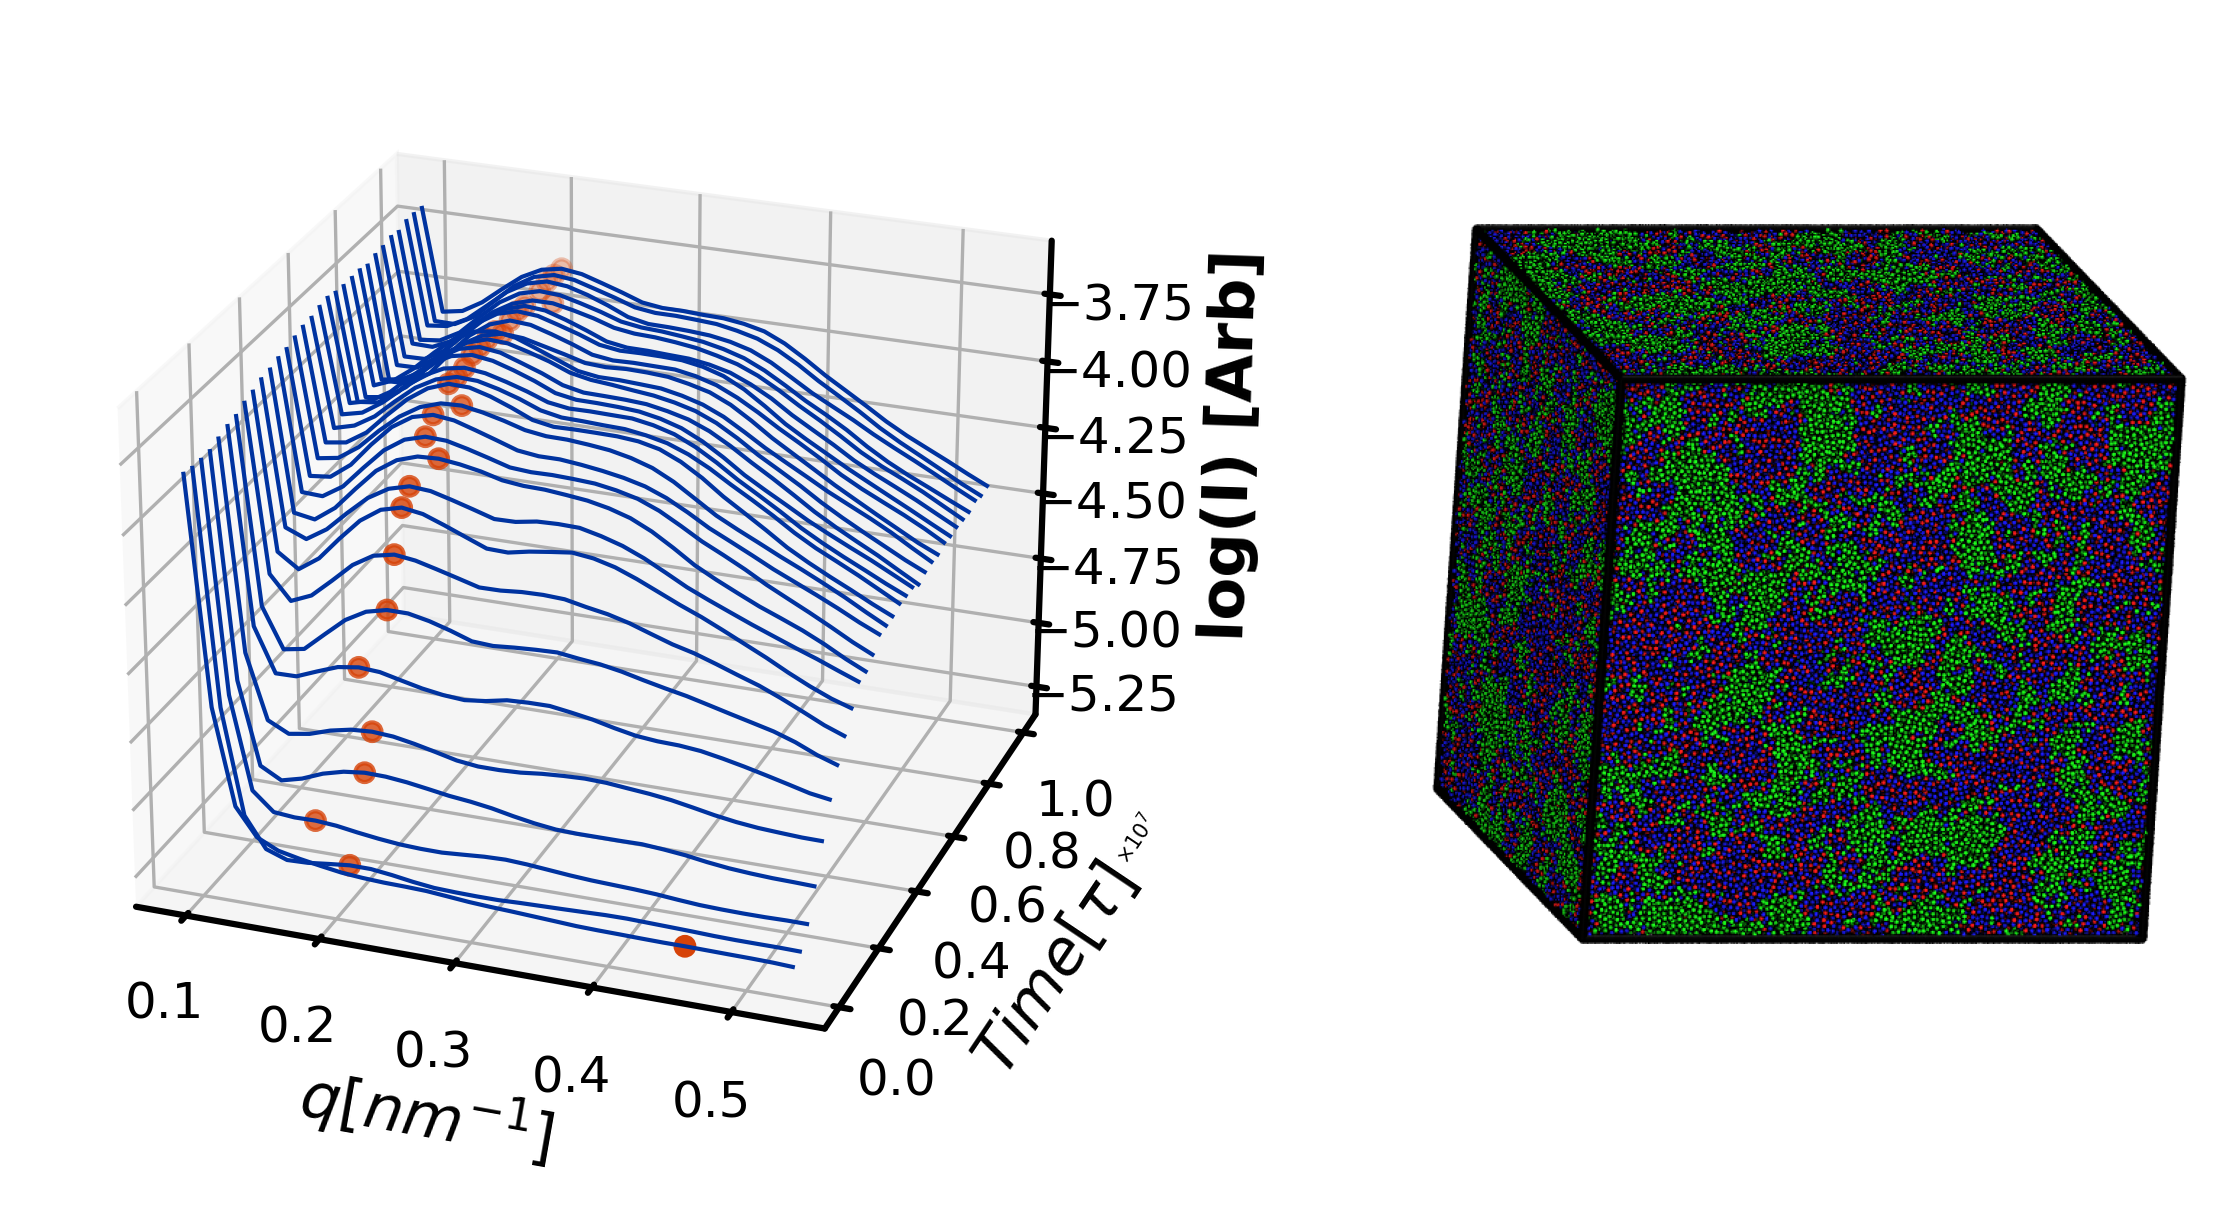

In [4]:
from matplotlib import rcParams
rcParams["xtick.minor.visible"] = False
rcParams["ytick.minor.visible"] = False

fig = plt.figure(dpi=300)
ax = fig.add_subplot(111, projection='3d')
#ax.set_title('z-axis left side')
#ax = fig.add_axes(MyAxes3D(ax, 'l'))
left, bottom, width, height = [0.88, 0.2, 0.6, 0.6]#max t2
ax2 = fig.add_axes([left, bottom, width, height])
ax2.axis('off')
qlim_max=35
qlim_min=6
Ilim=20
q = q_mean[0][qlim_min:qlim_max]
I=I_mean[:,qlim_min:qlim_max]
#print(q)
#print(I)
#X,Y = np.meshgrid(q_mean[0],time_mean)
X,Y = np.meshgrid(q,time_mean)

Z=I
#matplotlib.rcParams['xtick.labelsize'] = 15
#matplotlib.rcParams['ytick.labelsize'] = 15
#matplotlib.rcParams['xtick.major.pad'] = 2
#matplotlib.rcParams['ytick.major.pad'] = 2
#matplotlib.rcParams['ztick.major.pad'] = 1
#surf = ax.plot_surface(X, Y, Z, cmap=cm.plasma,)#,rstride=1, cstride=1,linewidth=1, antialiased=True)
surf = ax.plot_wireframe(X, Y, Z, linewidth=1.0,zorder=0.2,rstride=1, cstride=0, antialiased=True, color=BSU_BLUE)
view_1 = (0, 180)#back
view_2 = (25, -70)#angled
view_3 = (25, 0)#front from top
view_4 = (-5, 90)#right
view_5 = (10, -90)#angled
init_view = view_2
ax.view_init(*init_view)
ax.set_xlabel(r"$q [nm^{-1}]$", fontsize=15,rotation=150)
ax.set_ylabel(r"$Time[\tau]$",fontsize=15, rotation=150)
ax.set_zlabel("log(I) [Arb]", fontsize=15,rotation=90, labelpad=10)
#ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True,rotation=0,labelsize=1)
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
#ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0), useMathText=True)
ax.yaxis.offsetText.set_fontsize(5)
ax.tick_params(axis = 'both',labelsize=12,pad=3)
#print(q_half_length,Is_av[:101])
ax.scatter3D(qs_av, time_mean, Is_av,color=BSU_ORANGE,zorder=0.5,marker='o',antialiased=True,s=20)
if job.isfile('final_snapshot.png'):
    im = plt.imread(job.fn('final_snapshot.png'))
    #ax2.set_title('job:{}'.format(job),fontsize=8)
    ax2.imshow(im,zorder=1)
plt.savefig('morphology_evolution_1e6.png',transparent=True, bbox_inches='tight')
plt.show()
